In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

df = pd.read_csv("../datasets/Google.csv")
df.index = pd.DatetimeIndex(df['Date'].values)
close = df["Close"]

In [2]:
import numpy as np
import pandas as pd


def get_weights(d, size):
    w = [1.]
    for k in range(1, size):
        w_ = -w[-1] / k * (d - k + 1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w


def plot_weights(d_range, n_plots, size):
    w = pd.DataFrame()
    for d in np.linspace(d_range[0], d_range[1], n_plots):
        w_ = get_weights(d, size)
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1], columns=[d])
        w = w.join(w_, how='outer')
    ax = w.plot(figsize=(16, 8))
    ax.legend(loc='upper right')

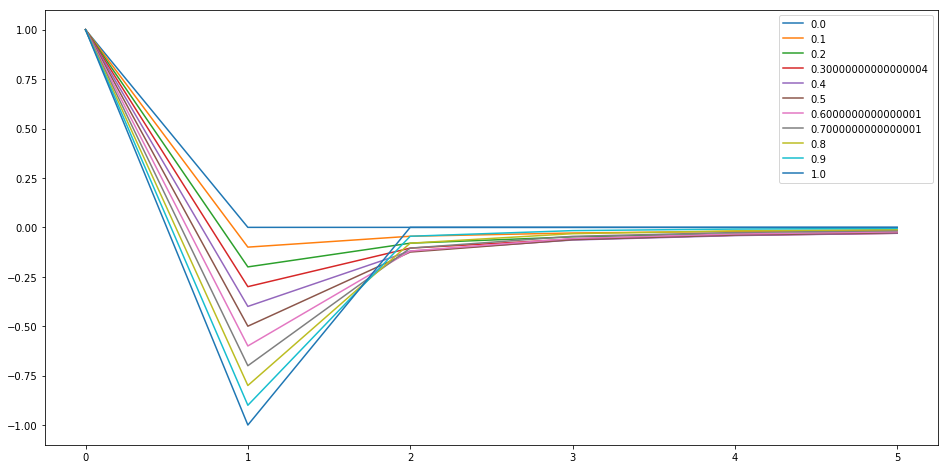

In [3]:
plot_weights([0, 1], 11, size=6)

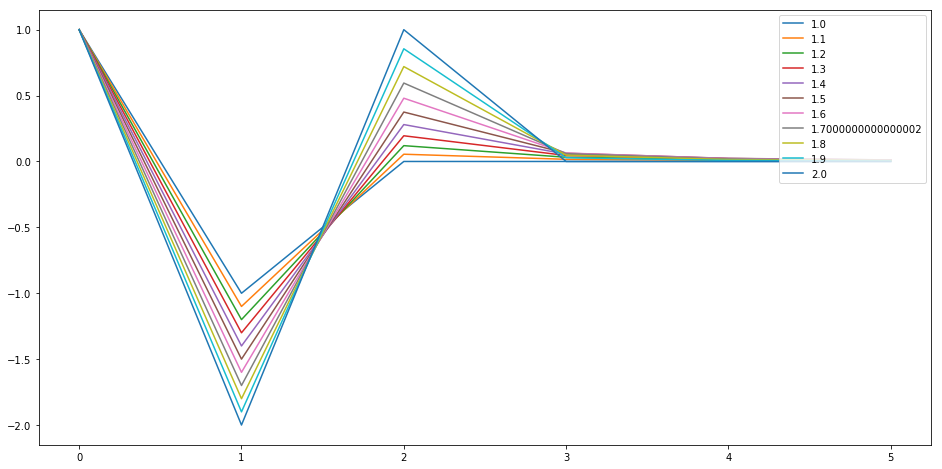

In [4]:
plot_weights([1, 2], 11, size=6)

In [5]:
def frac_diff(series, d, thres=.1):
    # w.shape = (series.shape[0], 1)
    w = get_weights(d, series.shape[0])
    w_sum = np.cumsum(abs(w))
    w_sum /= w_sum[-1]
    # Usable only after going over the threshold
    skip = w_sum[w_sum > thres].shape[0]
    df = {}
    for name in series.columns:
        series_f = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc in range(skip, series_f.shape[0]):
            loc = series_f.index[iloc]
            if not np.isfinite(series.loc[loc, name]):
                continue
            df_[loc] = np.dot(w[-(iloc + 1):, :].T, series_f.loc[:loc])[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [6]:
def frac_diff_FFD(series, d, thres=1e-5):
    w = get_weights_FFD(d, thres)
    width = len(w) - 1
    df = {}
    for name in series.columns:
        series_f = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc1 in range(width, series_f.shape[0]):
            loc0 = series_f.index[iloc1 - width]
            loc1 = series_f.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue
            df_[loc1] = np.dot(w.T, series_f.loc[loc0:loc1])[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [7]:
from statsmodels.tsa.stattools import adfuller

adfuller(close, 12)

/home/tomoaki/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(-2.4310671816546217,
 0.13315919893986067,
 1,
 3123,
 {'1%': -3.432445639802861,
  '10%': -2.567262891276225,
  '5%': -2.8624659237441654},
 25325.977157525936)

In [8]:
outputs = []
ds = np.linspace(0, 1, 11)
for d in ds:
    df1 = np.log(df[['Close']]).resample('1D').last()
    df2 = frac_diff(df1, d, thres=.1)
    df2 = adfuller(df2['Close'], maxlag = 1,regression = 'c',autolag = None)
    # Pvalue
    outputs.append(df2[1])


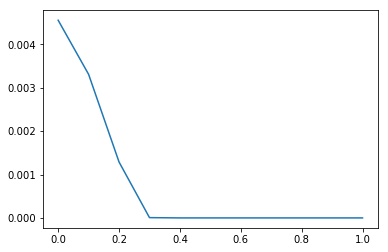

In [9]:
plt.plot(ds, outputs)

# 5.1

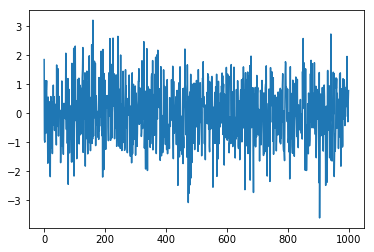

In [10]:
x = np.random.randn(1000)
plt.plot(x)

In [11]:
from statsmodels.tsa.stattools import adfuller


res = adfuller(x)
print(res)

p_val = res[1]
print("p-value: ", p_val)

(-32.8247093405595, 0.0, 0, 999, {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}, 2724.3632887028107)
p-value:  0.0


(-1.0841988393323927, 0.7213319164463725, 0, 999, {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}, 2724.6914123735705)
p-value:  0.7213319164463725


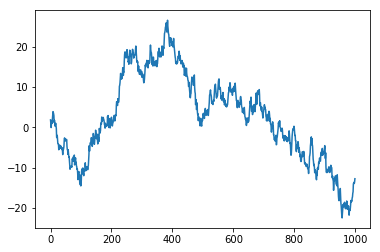

In [12]:
x_sum = x.cumsum()
plt.plot(x_sum)
res = adfuller(x_sum)
print(res)

p_val = res[1]
print("p-value: ", p_val)

(-13.251308027880501, 8.764632670605858e-25, 18, 979, {'1%': -3.4370471695043037, '5%': -2.8644967585264784, '10%': -2.5683443301882956}, 2779.4928640901026)
p-value:  8.764632670605858e-25


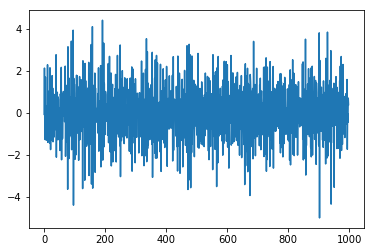

In [13]:
over_diff = np.diff(np.diff(x_sum))
plt.plot(over_diff)
res = adfuller(over_diff)
print(res)

p_val = res[1]
print("p-value: ", p_val)

# 5.2

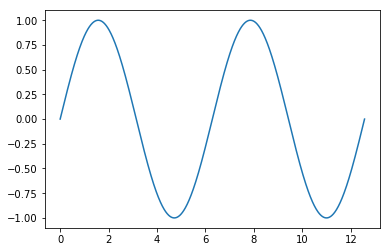

In [14]:
x = np.linspace(0, 4*np.pi, 1000)
y = np.sin(x)
plt.plot(x, y)

In [15]:
res = adfuller(y)
print(res)

p_val = res[1]
print("p-value: ", p_val)

(-60578028420846.48, 0.0, 13, 986, {'1%': -3.4369994990319355, '5%': -2.8644757356011743, '10%': -2.5683331327427803}, -66468.98189429524)
p-value:  0.0


# 5.4

In [16]:
def get_weights_FFD(d, thres, size=10000):
    w = [1.]
    for k in range(1, size):
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) <= thres:
            break
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

def frac_diff_FFD(series, d, thres=1e-5):
    w = get_weights_FFD(d, thres)
    width = len(w) - 1
    df = {}
    for name in series.columns:
        series_f = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc1 in range(width, series_f.shape[0]):
            loc0 = series_f.index[iloc1 - width]
            loc1 = series_f.index[iloc1]
            if not np.isfinite(series.loc[loc1, name]):
                continue
            df_[loc1] = np.dot(w.T, series_f.loc[loc0:loc1])[0, 0]
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

In [17]:
x = np.random.randn(df.shape[0])
dummy = pd.DataFrame({'Close': x.cumsum()}, index=df.index)

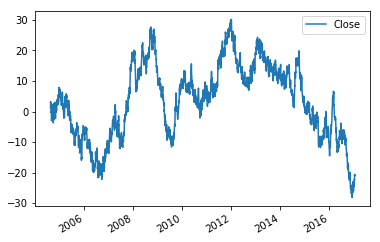

In [18]:
dummy.plot()

In [19]:
frac_df = frac_diff_FFD(dummy, .5)
frac_df.head()

,Close
2008-04-24,0.341830
2008-04-25,0.080560
2008-04-28,1.366998
2008-04-29,0.833227
2008-04-30,2.273546


In [20]:
frac_df = frac_diff_FFD(frac_diff_FFD(dummy, 1), -1)
frac_df.head()

,Close


In [21]:
corrs = []
ds = []
for d in np.linspace(0, 2, 11):
    frac_df = frac_diff_FFD(dummy, d)
    close_frac = frac_df["Close"]
    corr = close_frac.corr(dummy["Close"])
    print(d, corr)
    if np.isfinite(corr):
        corrs.append(corr)
        ds.append(d)

0.0 1.0
0.2 nan
0.4 0.7494767651866965
0.6000000000000001 0.37385762818095
0.8 0.14839962978101104
1.0 0.049702139183430756
1.2000000000000002 0.01173853807929471
1.4000000000000001 0.0014916464558962764
1.6 -0.0009347472756766786
1.8 -0.0012492743274609918
2.0 -0.00013139183013107452


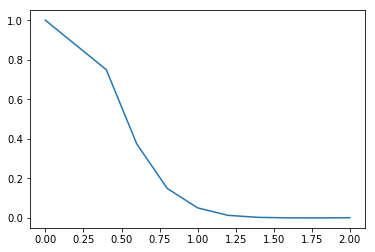

In [22]:
plt.plot(ds, corrs)

In [23]:
import statsmodels

ps = []
ds = []
for d in np.linspace(0, 2, 11):
    frac_df = frac_diff_FFD(dummy, d)
    close_frac = frac_df["Close"]
    close_ = dummy["Close"].loc[close_frac.index]
    if len(close_) > 0:
        # Coefficient of the first argument will change
        res = statsmodels.tsa.stattools.coint(close_frac, close_)
        ps.append(res[1])
        ds.append(d)

/home/tomoaki/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1018: UserWarning: y0 and y1 are perfectly colinear.  Cointegration test is not reliable in this case.
  warnings.warn("y0 and y1 are perfectly colinear.  Cointegration test "


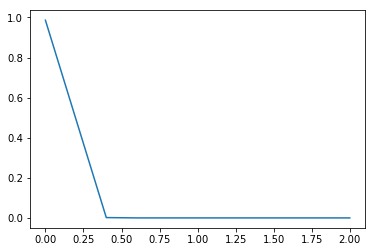

In [24]:
plt.plot(ds, ps)

In [25]:
ps

[0.9859002580259643,
 0.0016500001729594493,
 3.4241476040356815e-06,
 8.241844493525158e-11,
 1.905292725093347e-16,
 1.486178276722453e-20,
 1.1188126176620231e-24,
 2.3593472535989218e-27,
 7.841160843984151e-29,
 1.907586245190865e-29]

In [26]:
from scipy import stats

import statsmodels

ps = []
ds = []
for d in np.linspace(0, 2, 11):
    frac_df = frac_diff_FFD(dummy, d)
    close_frac = frac_df["Close"]
    if len(close_frac) > 0:
        # Coefficient of the first argument will change
        res = stats.jarque_bera(close_frac)
        ps.append(res[1])
        ds.append(d)

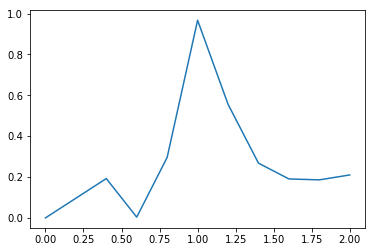

In [27]:
plt.plot(ds, ps)

In [28]:
ps

[0.0,
 0.19256909554935164,
 0.00382097956071048,
 0.29614207494675404,
 0.9670513001415704,
 0.556062541284073,
 0.26795184444641484,
 0.19063509477251905,
 0.18613335612111892,
 0.21030382745120735]

# 5.6

In [40]:
from finance_ml.stats import get_daily_vol
from finance_ml.labeling import cusum_filter, get_t1, get_events

In [32]:
df_ = df[["Close", "Open", "Low", "High"]]
frac_df = frac_diff_FFD(df_, 0.5)

In [35]:
vol = get_daily_vol(close)
events = cusum_filter(close, 2 * vol)

In [41]:
t1 = get_t1(close, events, num_days=5)
sampled = get_events(close, events, ptsl=2, trgt=vol, min_ret=0, num_threads=12,
               t1=t1, side=None)

/home/tomoaki/anaconda3/lib/python3.6/site-packages/finance_ml-0.1-py3.6.egg/finance_ml/labeling/barriers.py:37: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
2018-07-02 02:34:37.663817 100.0% apply_ptslt1 done after 0.0 minutes. Remaining 0.0 minutes..


In [43]:
data = sampled.dropna()
data

,t1,trgt,t1_type
2004-08-26,2004-08-31,0.027366,t1
2004-09-02,2004-09-07,0.024097,t1
2004-09-21,2004-09-27,0.020498,t1
2004-09-28,2004-10-04,0.024991,pt
2004-09-30,2004-10-05,0.024733,pt
2004-10-18,2004-10-20,0.022150,sl
2004-10-20,2004-10-21,0.024583,pt
2004-10-21,2004-10-22,0.026541,pt
2004-10-25,2004-11-01,0.030133,t1
2004-10-26,2004-10-28,0.030639,pt


In [50]:
features_df = frac_df.loc[data.index].dropna()
features = features_df.values
label = data['t1_type'].loc[features_df.index].values

/home/tomoaki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [51]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(features, label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
clf.predict(features)

array(['t1', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 'sl', 'pt', 't1',
       't1', 't1', 'pt', 'pt', 't1', 'sl', 'pt', 't1', 'sl', 'pt', 't1',
       'sl', 'sl', 'pt', 'sl', 'sl', 'sl', 't1', 't1', 'sl', 't1', 't1',
       't1', 'pt', 't1', 'sl', 'sl', 'sl', 'pt', 'pt', 't1', 't1', 't1',
       't1', 't1', 't1', 't1', 't1', 't1', 't1', 'sl', 't1', 'pt', 't1',
       't1', 't1', 'pt', 't1', 't1', 'pt', 't1', 't1', 't1', 'pt', 't1',
       't1', 't1', 'pt', 't1', 't1', 't1', 't1', 'sl', 't1', 't1', 't1',
       't1', 'pt', 't1', 't1', 't1', 'sl', 'sl', 't1', 't1', 'pt', 'sl',
       'pt', 't1', 't1', 't1', 't1', 't1', 't1', 't1', 'pt', 't1', 't1',
       'sl', 'pt', 'pt', 't1', 't1', 'sl', 'sl', 't1', 't1', 'pt', 'pt',
       't1', 't1', 't1', 't1', 't1', 't1', 't1', 'sl', 'pt', 't1', 'sl',
       'sl', 'sl', 't1', 't1', 't1', 't1', 't1', 'sl', 'pt', 't1', 't1',
       't1', 't1', 't1', 't1', 't1', 'pt', 't1', 't1', 't1', 't1', 'sl',
       'pt', 't1', 'pt', 'pt', 'pt', 'pt', 'pt', 't